In [5]:
#The following code is used to format data originally stored in an Excel spreadsheet. The Excel sheet was converted to a CSV file, and the CSV file was converted to a NetCDF file using panda's read_csv function, and xarray's from_dataframe and to_netcdf functions, as in the code lines below. I have them commented out because it was only necessary to run this bit of code once before proceeding to work with the netcdf file.
#Note: The following code works better if I download the Excel sheet and THEN save as a .csv file,  rather than simply downloading as a .csv from Google Drive. Not sure why this is.

# import pandas as pd
# import xarray as xr
# !cd '/Users/bennysmith/Documents/Climate_Science/Research_with_Baylor'
# !rm 'DOH_2018.nc'
# mySeries = pd.read_csv('/Users/bennysmith/Documents/Climate_Science/Research_with_Baylor/DOH_2018.csv')
# myDataset = xr.Dataset.from_dataframe(mySeries)
# attribute = {'title': 'DOH 2018'}
# myDataset.assign_attrs(attribute)
# DOH_2018nc = myDataset.to_netcdf('/Users/bennysmith/Documents/Climate_Science/Research_with_Baylor/DOH_2018.nc')

#The following code chunk is similar: it takes a .csv file with lat & lon corresponding to some beaches (which originally was an Excel file), and converts it to .nc
# mySeries = pd.read_csv('/Users/bennysmith/Documents/Climate_Science/Research_with_Baylor/beach_coordinates.csv')
# myDataset = xr.Dataset.from_dataframe(mySeries)
# DOH_2018nc = myDataset.to_netcdf('/Users/bennysmith/Documents/Climate_Science/Research_with_Baylor/beach_coordinates.nc')

#Same thing here with the labdataentry_ALL csv file: 
# mySeries = pd.read_csv('/Users/bennysmith/Documents/Climate_Science/Research_with_Baylor/labdataentry_ALL_use.csv')
# myDataset = xr.Dataset.from_dataframe(mySeries)
# DOH_2018nc = myDataset.to_netcdf('/Users/bennysmith/Documents/Climate_Science/Research_with_Baylor/labdataentry_ALL.nc')

#Same thing here with an EPA spreadsheet with lat & lon data:
# mySeries = pd.read_csv('/Users/bennysmith/Documents/Climate_Science/Research_with_Baylor/ridata2012_epastuff.csv')
# myDataset = xr.Dataset.from_dataframe(mySeries)
# DOH_2018nc = myDataset.to_netcdf('/Users/bennysmith/Documents/Climate_Science/Research_with_Baylor/ridata2012_epastuff.nc')

#Now that the first netcdf file has been created, I need to re-format it. The original netcdf file does not have attributes, and has all its variables dependent on an 'index' dimension. Instead, I would like to get observations to be dependent on time and BeachID dimensions. Since there are not observations at every time for every BeachID, there will be many NaN values in the netcdf file I'm trying to create. There are a variety of other formatting pieces that need to be changed as well.

#helpful link about working with netcdf4: https://iescoders.com/writing-netcdf4-data-in-python/
#helpful link for strptime formatting: https://www.journaldev.com/23365/python-string-to-datetime-strptime
#helpful link with examples of netcdf4.date2num(): https://www.programcreek.com/python/example/89490/netCDF4.date2num
#a few imports and installations:
import math
import netCDF4 as nc
from netCDF4 import Dataset as NetCDFFile
from netCDF4 import date2num
import xarray as xr
from datetime import datetime as dt
import numpy as np
#The following 2 lines just remove the preexisting version of 'test.nc'. As I was building this code, I had to create and delete the test.nc file many times.
!cd /Users/bennysmith/Documents/Climate_Science/Research_with_Baylor
!rm testing.nc

#opening the original .nc file with the data I'd like to format into a new netcdf file:
mydirectory = '/Users/bennysmith/Documents/Climate_Science/Research_with_Baylor'
ncstart = NetCDFFile(mydirectory+'/DOH_2018_SAFE.nc')
#defining the variables stored in the original netcdf:
BeachID_start = ncstart.variables['BeachID']
CollectionTime_start = ncstart.variables['CollectionTime']
Duplicate_start = ncstart.variables['Duplicate']
LabID_start = ncstart.variables['LabID']
SampleID_start = ncstart.variables['SampleID']
Sampler_start = ncstart.variables['Sampler']
SWresults_start = ncstart.variables['SWresults']
Test_Type_start = ncstart.variables['Test_Type']
Validation_start = ncstart.variables['Vaildation'] #there's a typo in the original spreadsheet
WaterType_start = ncstart.variables['WaterType']

#Below, I convert SampleIDs from strings to floats in order to be able to have NaNs in the final netcdf file. Thus, where the original dataset had SampleIDs of the form '1802186-01', now they will be floats of the form 1802186.01
SampleID_floatstart = []
for i in SampleID_start:
    i = i.replace('-', '.')
    i = float(i)
    SampleID_floatstart.append(i)

#converting the strings representing time in the original netcdf file to numbers. Time will be measured in minutes since 2018-05-24 13:20:00 in this dataset.
timelist = []
for i in CollectionTime_start:
    timelist.append(dt.strptime(i, '%m/%d/%y %I:%M %p'))
timelist2 = date2num(timelist, 'minutes since 2018-05-24 13:20:00')

#creating lists of unique times and BeachIDs:    
BeachID_unique = []
for i in BeachID_start:
    if i not in BeachID_unique:
        BeachID_unique.append(i)
timelist2_unique = []
for i in timelist2:
    if i not in timelist2_unique:
        timelist2_unique.append(i)         
# print(len(timelist2_unique))
# print(len(BeachID_unique))

#getting lat & lon data from an EPA spreadsheet corresponding to beach IDs
mydirectory = '/Users/bennysmith/Documents/Climate_Science/Research_with_Baylor'
epanc = NetCDFFile(mydirectory+'/ridata2012_epastuff.nc')
epaBeachIDs = epanc.variables['Beach ID']
newncBeachIDsl = []
for i in BeachID_start:
    newncBeachIDsl.append(i)
epaBeachIDsl = []
for j in epaBeachIDs:
    epaBeachIDsl.append(j)

#Need to get just the data that overlaps between the EPA spreadsheet and the data I'm actually trying to convert
overlapepa_dict = {
    'Beach ID': [],
    'Start latitude': [],
    'Start longitude': [],
    'End latitude': [],
    'End longitude': [],
    'Midpoint latitude': [],
    'Midpoint longitude': []
}
for k in epaBeachIDsl:
    if k in newncBeachIDsl: #testing to see if the data is in both the EPA data and the RIDOH data, then adding it to the dictionary above
        overlapepa_dict['Beach ID'].append(k)
        overlapepa_dict['Start latitude'].append(float(epanc.variables['Start latitude'][epaBeachIDsl.index(k)]))
        overlapepa_dict['Start longitude'].append(float(epanc.variables['Start longitude'][epaBeachIDsl.index(k)]))
        overlapepa_dict['End latitude'].append(float(epanc.variables['End latitude'][epaBeachIDsl.index(k)]))
        overlapepa_dict['End longitude'].append(float(epanc.variables['End longitude'][epaBeachIDsl.index(k)]))
#One of the longitudes is incorrectly listed as 71ish rather than -71ish, so I multiply by -1:
for i in range(len(overlapepa_dict['Start longitude'])):
    if overlapepa_dict['Start longitude'][i]>0:
        overlapepa_dict['Start longitude'][i] = -1*overlapepa_dict['Start longitude'][i]
    if overlapepa_dict['End longitude'][i]>0:
        overlapepa_dict['End longitude'][i] = -1*overlapepa_dict['End longitude'][i]
#One of the longitudes is missing a decimal point, so I fix that here:
for i in range(len(overlapepa_dict['Start longitude'])):
    if overlapepa_dict['Start longitude'][i] == -71473461:
        overlapepa_dict['Start longitude'][i] = -71.473461
#Averaging Start and End Latitudes and Longitudes to get 'midpoints' that I'll use as the beach locations in the NetCDF file
midpoints = []
for x in range(len(overlapepa_dict['Beach ID'])):
    midpoint_lat = (overlapepa_dict['Start latitude'][x] + overlapepa_dict['End latitude'][x])/2
    midpoint_lon = (overlapepa_dict['Start longitude'][x] + overlapepa_dict['End longitude'][x])/2
    overlapepa_dict['Midpoint latitude'].append(midpoint_lat)
    overlapepa_dict['Midpoint longitude'].append(midpoint_lon)

# 63 of the 69 Beach IDs recorded in the csv I'm trying to convert are also in the EPA file listing latitudes and longitudes. I need to figure out what the other 6 are.
# print(len(overlapepa_dict['Beach ID']))
# print(len(BeachID_unique))
# extras = []
# for i in BeachID_unique:
#     if i not in overlapepa_dict['Beach ID']:
#         extras.append(i)
# print(extras)
# The 6 others are: ['RI501547', 'RI215063', 'RI104171', 'RI425865', 'RI299364', 'RI380247']
# I found the following coordinates using Google Earth Pro (might want to double check before putting final version of the .nc file on the ERDDAP server):
# RI501547: Rose Larisa Beach: lat 41.756, lon -71.361
# RI215063: Sabins Point: lat 41.765, lon -71.3528
# RI104171: Green Hill Beach: lat 41.3653, lon -71.595
# RI425865: Atlantic Beach Casino Resort: lat 41.3242, lon -71.794
# RI299364: Weekapaug Fire District: lat 41.3261, lon -71.7506
# RI380247: Misquamicut Fire District Beach: lat 41.32056, lon -71.81361
extras_dict = {
    'Beach ID': ['RI501547', 'RI215063', 'RI104171', 'RI425865', 'RI299364', 'RI380247'],
    'Latitude': [41.756, 41.765, 41.3653, 41.3242, 41.3261, 41.32056],
    'Longitude': [-71.361, -71.3528, -71.595, -71.794, -71.7506, -71.81361]
}

#NEXT: Combine the 63 and the 6
tempBeachIDs = overlapepa_dict['Beach ID'] + extras_dict['Beach ID']
tempLatitudes = overlapepa_dict['Midpoint latitude'] + extras_dict['Latitude']
tempLongitudes = overlapepa_dict['Midpoint longitude'] + extras_dict['Longitude']
#Need to reorder the tempLatitudes and tempLongitudes lists to correspond to BeachID_unique
finalLatitudes = []
finalLongitudes = []
for y in BeachID_unique:
    finalLatitudes.append(tempLatitudes[tempBeachIDs.index(y)])
    finalLongitudes.append(tempLongitudes[tempBeachIDs.index(y)])
    
#Getting the beach names into a list, and in the same order as BeachID_unique, so that you can access the location names in the NetCDF file:
labdataALLnc = NetCDFFile(mydirectory+'/labdataentry_ALL.nc')
priorBeachIDs = labdataALLnc.variables['BeachID']
priornames = labdataALLnc.variables['Name']
BeachID_labdataALL = []
for i in priorBeachIDs:
    BeachID_labdataALL.append(i)
Name_labdataALL = []
for i in priornames:
    Name_labdataALL.append(i)
Names_unique = []
for j in Name_labdataALL:
    if j not in Names_unique:
        Names_unique.append(j)
useful_Names = []
for n in BeachID_unique:
    useful_Names.append(Name_labdataALL[BeachID_labdataALL.index(n)])
        
#In the original netcdf file, the observation variables are simple lists of numbers. Instead, I want them to be 2D grids. In each grid, the first dimension should have the length of the number of unique times, and the second dimension should hvae the length of the number of unique Beach IDs. By printing those lengths above, I know that the grids must be 1386*69. The following chunk of code allows me to regrid the data correctly.
#The following dictionary of variables and list of variable nameswill help in the for loops I use for regridding.
var_startdict = {
    'Duplicate': Duplicate_start,
    'SampleID': SampleID_floatstart,
    'Sampler': Sampler_start,
    'Test_Type': Test_Type_start,
    'Validation': Validation_start,
    'WaterType': WaterType_start,
    'SWresults': SWresults_start,
    'LabID': LabID_start
}
obs2d_dict_keyslist = ['Duplicate', 'SampleID', 'Sampler', 'Test_Type', 'Validation', 'WaterType', 'SWresults', 'LabID']
obs2d_dict = {} #I'll append to this dictionary in the for loop below
#The following 2 lines fill obs2d_dict with 1386*69 grids of nans. The key names are taken from obs2d_dict_keyslist.
for i in obs2d_dict_keyslist:
    obs2d_dict[i] = np.full((1386, 69), np.nan)
#Next, I use a for loop to add in the data to the grid of nans. In the first 2 nested for loops, I'm looping through each unique time and Beach ID
for i in range(len(timelist2_unique)):
    print(i)
    for j in range(len(BeachID_unique)):
        for k in range(1461): #For each time, BeachID (i, j) coordinate, I test whether entry k in the original netcdf time and BeachID variables matches up. If it does, I put in the corresponding entry of other variables such as SWresults at location i,j of its 1386*69 grid. I do this for everything listed in obs2d_dict_keyslist
            if timelist2[k] == timelist2_unique[i] and BeachID_start[k] == BeachID_unique[j]:
                for z in obs2d_dict_keyslist:
                    obs2d_dict[z][i][j] = var_startdict[z][k]
                
#Making the netcdf file:
mync = nc.Dataset('testing.nc', 'w', format='NETCDF4')
time_dim = mync.createDimension('time', 1386)
BeachID_dim = mync.createDimension('BeachID', 69)

#Below I create a bunch of variables. 
#Helpful link about data types: https://pbpython.com/pandas_dtypes.html
#time_var and Beach_ID var depend only on their corresponding dimensions.
time_var = mync.createVariable('time', np.float64, ('time',))
BeachID_var = mync.createVariable('BeachID', np.str, ('BeachID',))
Latitude_var = mync.createVariable('Latitude', np.float64, ('BeachID',))
Longitude_var = mync.createVariable('Longitude', np.float64, ('BeachID',))
Name_var = mync.createVariable('Beach Name', np.str, ('BeachID',))
#The following variables having to do with observations depend on both the time and BeachID dimensions. They are all stored as floats in order to have NaN values stored.
Duplicate_var = mync.createVariable('Duplicate', np.float64, ('time', 'BeachID'))
SampleID_var = mync.createVariable('SampleID', np.float64, ('time', 'BeachID'))
Sampler_var = mync.createVariable('Sampler', np.float64, ('time', 'BeachID'))
Test_Type_var = mync.createVariable('Test_Type', np.float64, ('time', 'BeachID'))
Validation_var = mync.createVariable('Validation', np.float64, ('time', 'BeachID'))
WaterType_var = mync.createVariable('WaterType', np.float64, ('time', 'BeachID'))
SWresults_var = mync.createVariable('SWresults', np.float64, ('time','BeachID'))
LabID_var = mync.createVariable('LabID', np.float64, ('time', 'BeachID'))

#Next I assign the data from the 1386*69 grids created earlier to the empty variables I just created
time_var[:] = timelist2_unique[:] #The index and colon are very important; if you don't include these it will just reset the values of the values, which prevents the data from being saved to the new netcdf.
for i in range(len(BeachID_unique)):
    BeachID_var[i] = BeachID_unique[i]
    Latitude_var[i] = finalLatitudes[i]
    Longitude_var[i] = finalLongitudes[i]
    Name_var[i] = useful_Names[i]
Duplicate_var[:,:] = obs2d_dict['Duplicate'][:,:]
SampleID_var[:,:] = obs2d_dict['SampleID'][:,:]
Sampler_var[:,:] = obs2d_dict['Sampler'][:,:]
Test_Type_var[:,:] = obs2d_dict['Test_Type'][:,:]
Validation_var[:,:] = obs2d_dict['Validation'][:,:]
WaterType_var[:,:] = obs2d_dict['WaterType'][:,:]
SWresults_var[:,:] = obs2d_dict['SWresults'][:,:]
LabID_var[:,:] = obs2d_dict['LabID'][:,:]

#Defining attributes of the entire dataset.
mync.title = 'DOH Data for EPA 2018'
mync.history = 'Converted from Excel spreadsheet provided by the Rhode Island Department of Health'
mync.institution = 'Rhode Island Department of Health'
mync.source = 'Rhode Island Department of Health lab measurements using samples from beach locations'
mync.comment = 'See elsewhere on the RIDDC ERDDAP server for information about a project by Brown University undergraduate Ella Wood using this data.'
mync.references = 'Data from Sherry Poucher at the RIDOH Beach Monitoring Program, Sherry.Poucher@health.ri.gov'

#Defining attributes of each dataset variable:
time_var._CoordinateAxisType = 'Time'
time_var.actual_range = '0, 140951'
time_var.axis = 'T'
time_var.calendar = 'standard'
time_var.ioos_category = 'Time' #not sure what ioos_category means
time_var.long_name = 'EDT Sample Time' #I need to double check this...
time_var.short_name = 'time'
time_var.standard_name = 'time'
time_var.time_origin = '2018-05-24 13:20:00'
time_var.units = 'minutes since 2018-05-24 13:20:00'

BeachID_var.long_name = 'Beach ID'
BeachID_var.standard_name = 'Beach_ID'

Latitude_var.long_name = 'latitude'
Latitude_var.units = 'degrees_north'
Latitude_var.standard_name = 'latitude'
Latitude_var.comment = '63 of the latitude values were found using an EPA spreadsheet available online that lists Start Latitude and End Latitude for 63 beach IDs. To find the single latitude values here, I took the average of Start Latitude and End Latitude. The other 6 latitudes were found using Google Earth. The following is the list of Beach IDs for which I used Google Earth: RI501547, RI215063, RI104171, RI425865, RI299364, RI380247. The EPA spreadsheet is at the following url: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwj2vLbivNfrAhWCJ80KHbZQB7sQFjAAegQIBhAB&url=https%3A%2F%2F19january2017snapshot.epa.gov%2Fsites%2Fproduction%2Ffiles%2F2013-09%2Fridata2012.xlsx&usg=AOvVaw3NJteVOpNlhSeeGFkouG47'

Longitude_var.long_name = 'longitude'
Longitude_var.units = 'degrees_east'
Longitude_var.standard_name = 'longitude'
Longitude_var.comment = '63 of the longitude values were found using an EPA spreadsheet available online that lists Start Longitude and End Longitude for 63 beach IDs. To find the single longitude values here, I took the average of Start Longitude and End Longitude. The other 6 longitudes were found using Google Earth. The following is the list of Beach IDs for which I used Google Earth: RI501547, RI215063, RI104171, RI425865, RI299364, RI380247. The EPA spreadsheet is at the following url: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwj2vLbivNfrAhWCJ80KHbZQB7sQFjAAegQIBhAB&url=https%3A%2F%2F19january2017snapshot.epa.gov%2Fsites%2Fproduction%2Ffiles%2F2013-09%2Fridata2012.xlsx&usg=AOvVaw3NJteVOpNlhSeeGFkouG47'

Name_var.long_name = 'Name of Beach'
Name_var.standard_name = 'Name_of_Beach'

Duplicate_var.long_name = 'Duplicate'
Duplicate_var.standard_name = 'Duplicate'

LabID_var.long_name = 'Lab ID'
LabID_var.standard_name = 'Lab_ID'

SampleID_var.long_name = 'Sample ID'
SampleID_var.standard_name = 'Sample_ID'
SampleID_var.comment = 'Before conversion to NetCDF, Sample IDs were of the form "1802186-01." They have been converted to float64 data of the form 1802186.01 in order to allow for NaN values.'

Sampler_var.long_name = 'Sampler'
Sampler_var.standard_name = 'Sampler'

Test_Type_var.long_name = 'Test Type'
Test_Type_var.standard_name = 'Test_Type'
Test_Type_var.explanation = 'Test_Type = 1 means the Enterolert method. Test_Type = 2 means the membrane filtration method, which is no longer used. This information is from Sonia Coronado at URI'

Validation_var.long_name = 'Validation'
Validation_var.standard_name = 'Validation'

WaterType_var.long_name = 'Water Type'
WaterType_var.standard_name = 'Water_Type'

SWresults_var.actual_range = '10, 24200'
SWresults_var.long_name = 'Enterococci Counts in colony-forming units'
SWresults_var.short_name = 'ECounts'
SWresults_var.standard_name = 'Enterococci_Counts_in_colony-forming_units'
SWresults_var.units = 'colony-forming unit'
        
mync.close() #this is a VERY important line!! If you don't close the file, not all the data gets written
print('done')

rm: testing.nc: No such file or directory
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266


odict_keys(['time', 'BeachID', 'Latitude', 'Longitude', 'Beach Name', 'Duplicate', 'SampleID', 'Sampler', 'Test_Type', 'Validation', 'WaterType', 'SWresults', 'LabID'])
<class 'netCDF4._netCDF4.Variable'>
float64 SWresults(time, BeachID)
    actual_range: 10, 24200
    long_name: Enterococci Counts in colony-forming units
    short_name: ECounts
    standard_name: Enterococci_Counts_in_colony-forming_units
    units: colony-forming unit
unlimited dimensions: 
current shape = (1386, 69)
filling on, default _FillValue of 9.969209968386869e+36 used



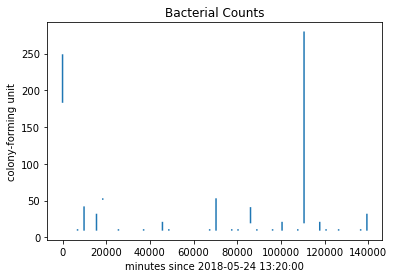

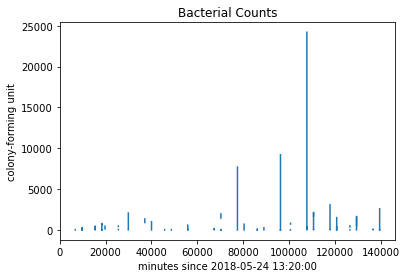

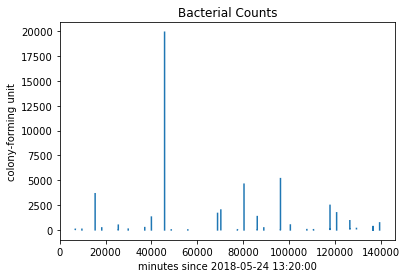

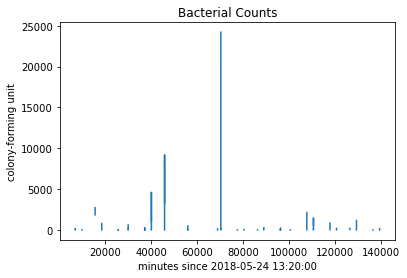

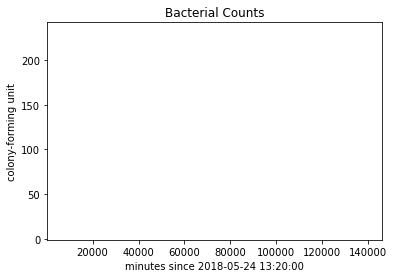

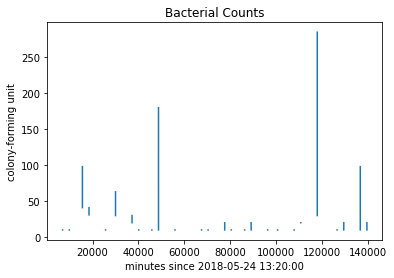

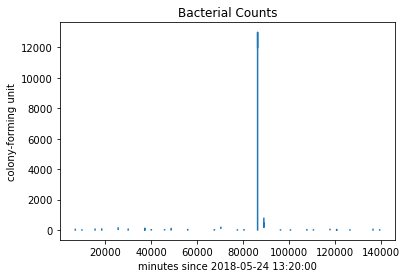

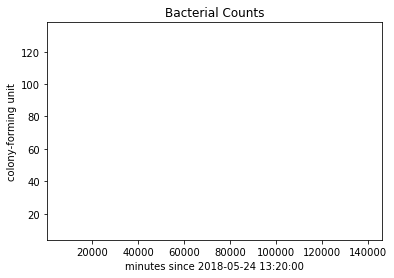

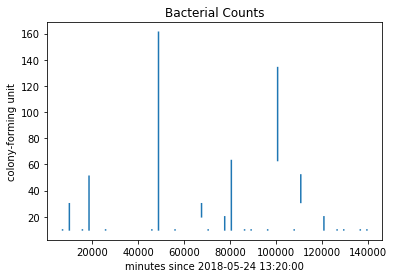

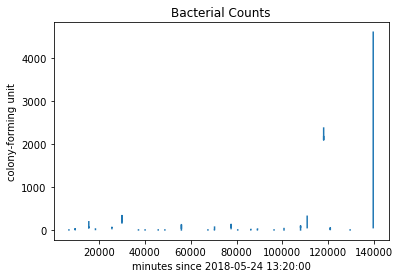

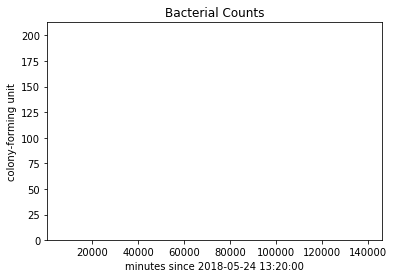

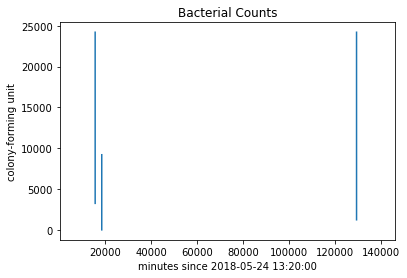

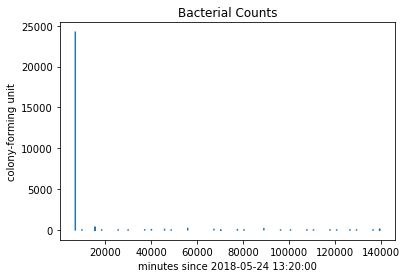

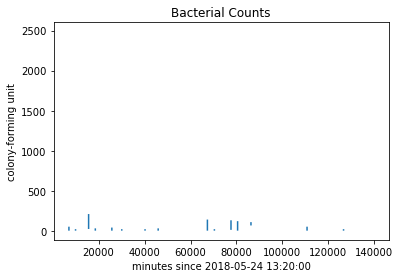

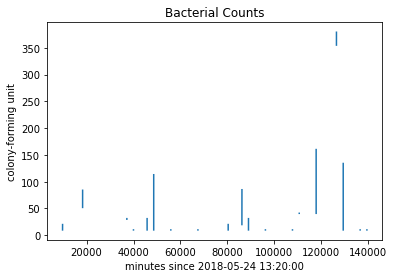

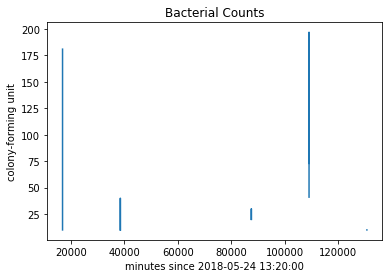

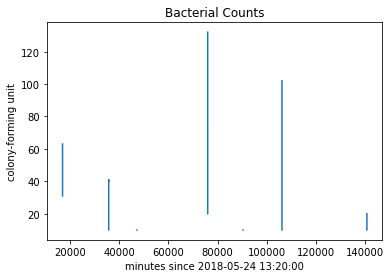

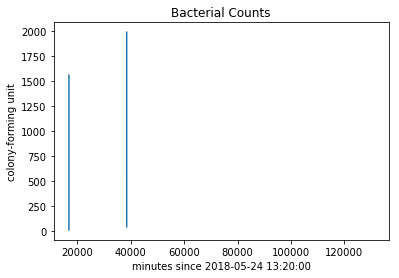

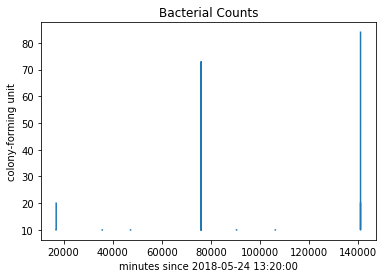

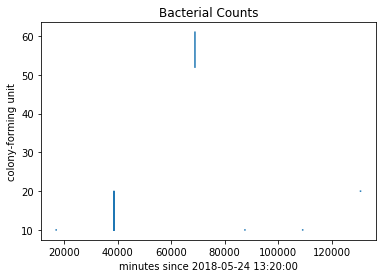

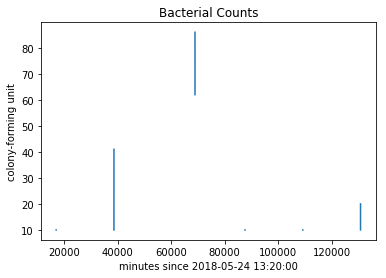

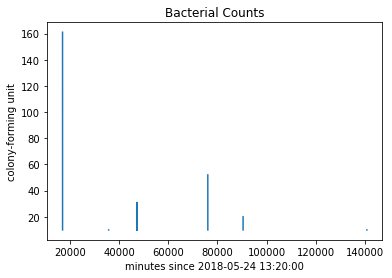

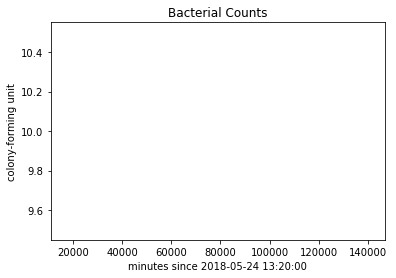

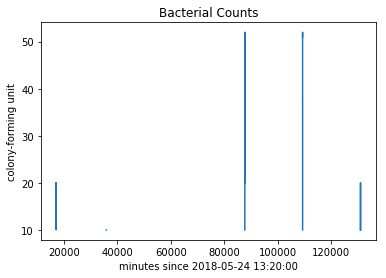

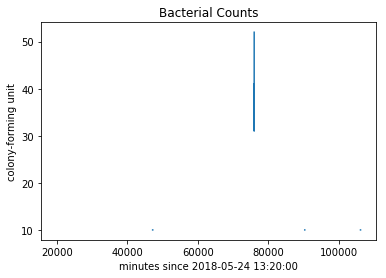

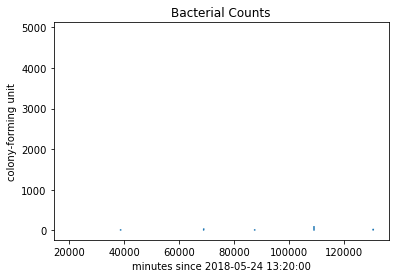

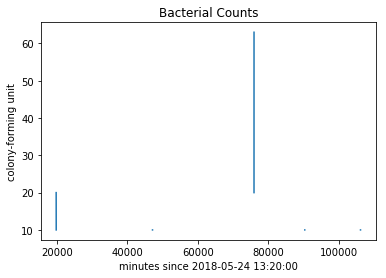

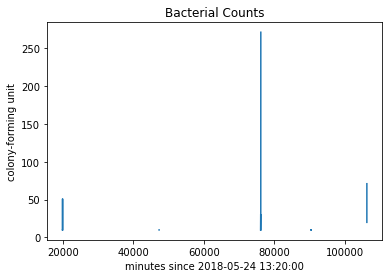

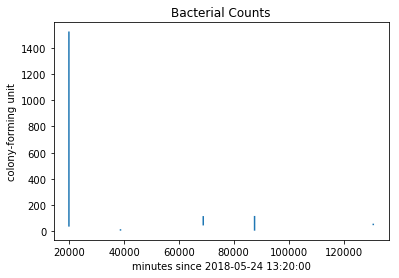

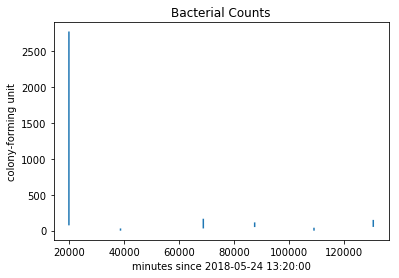

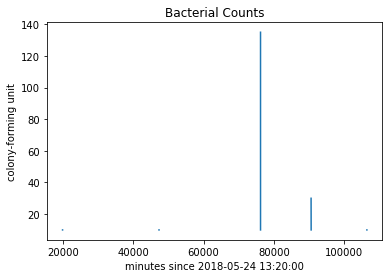

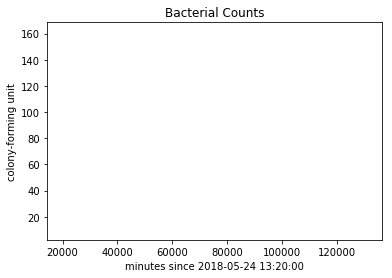

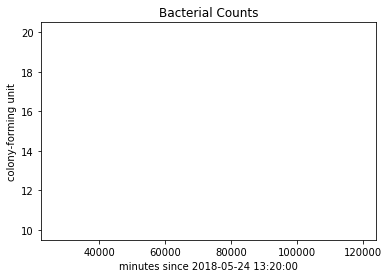

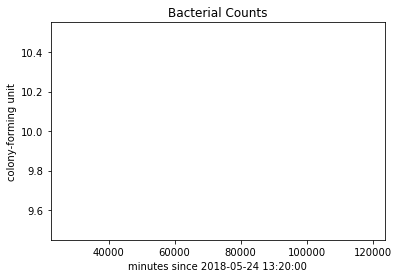

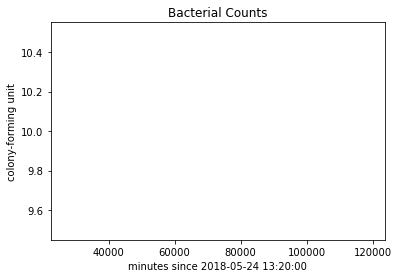

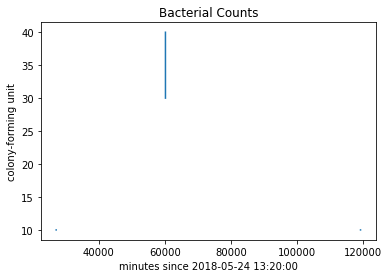

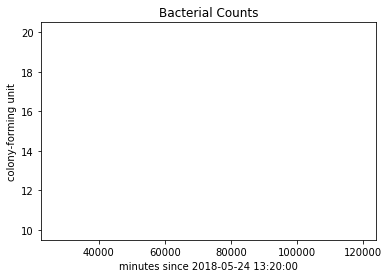

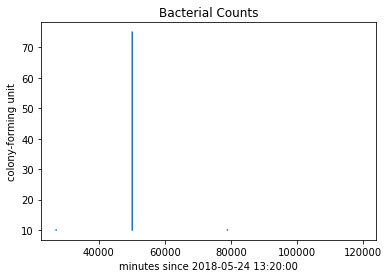

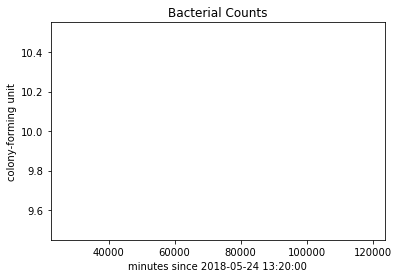

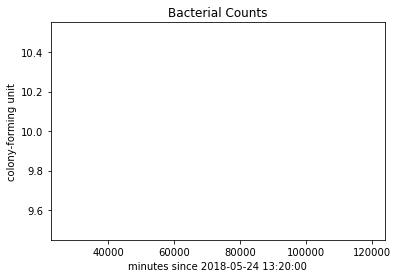

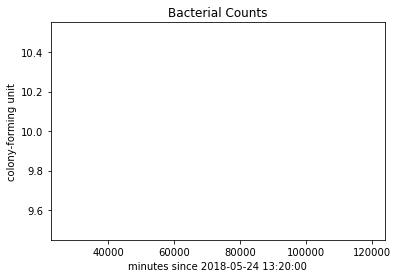

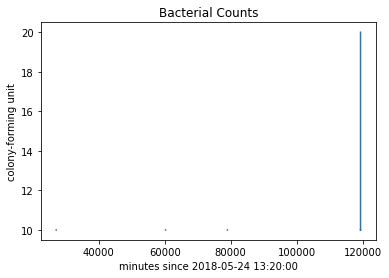

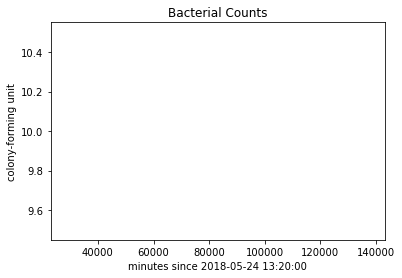

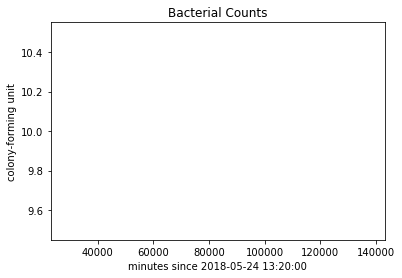

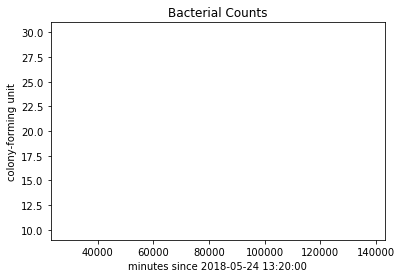

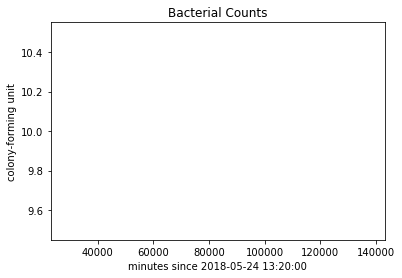

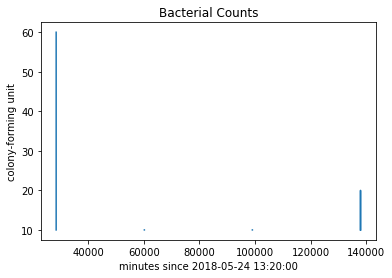

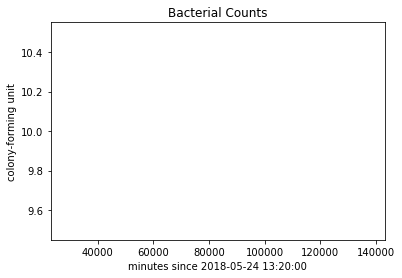

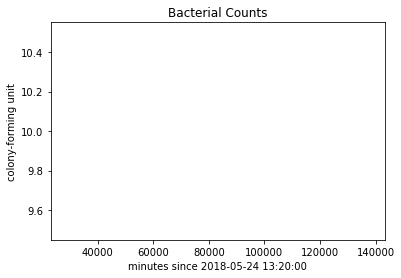

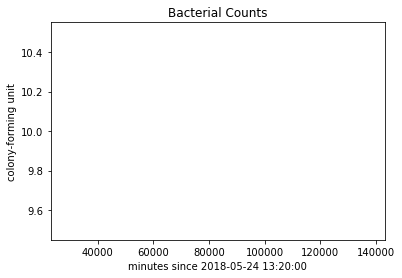

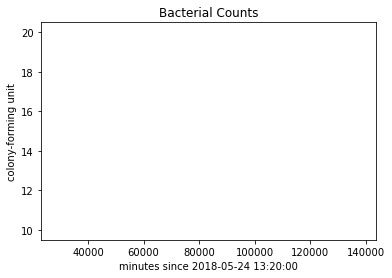

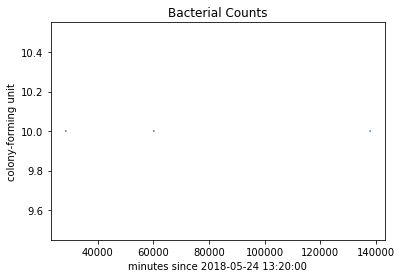

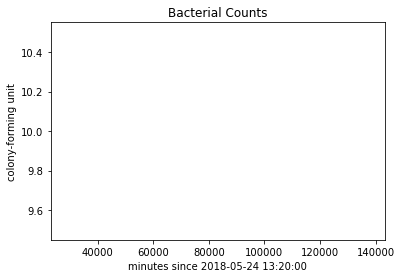

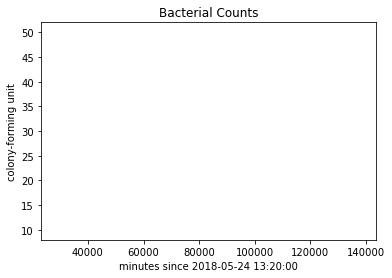

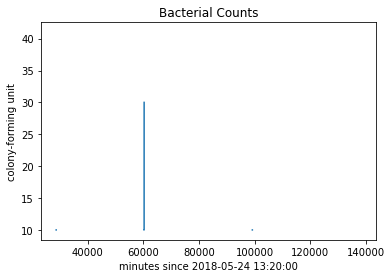

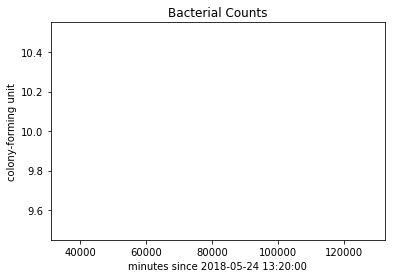

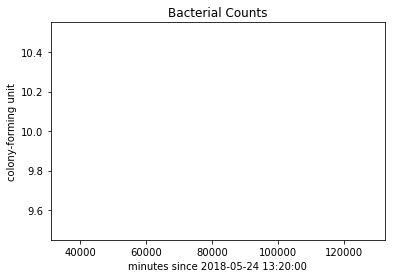

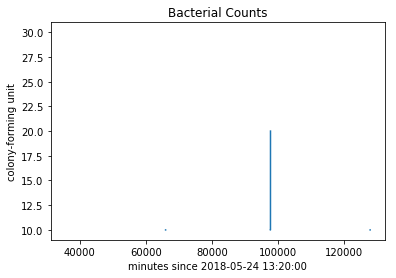

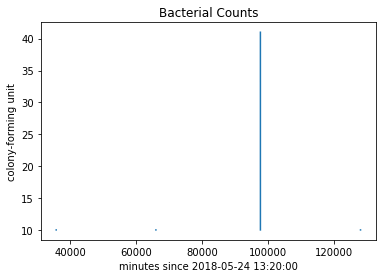

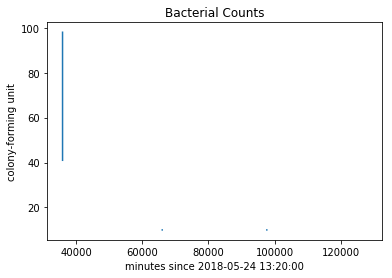

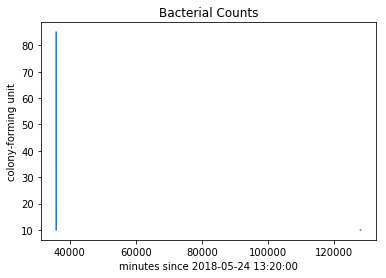

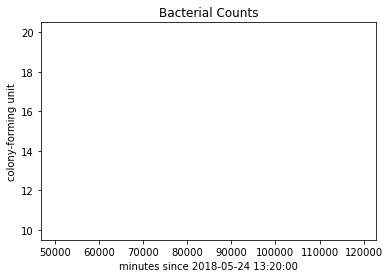

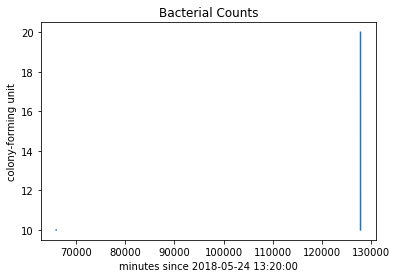

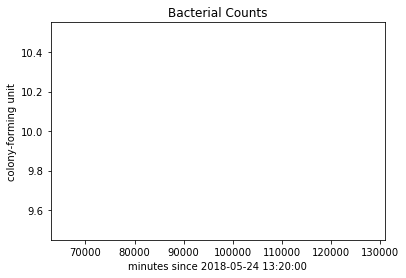

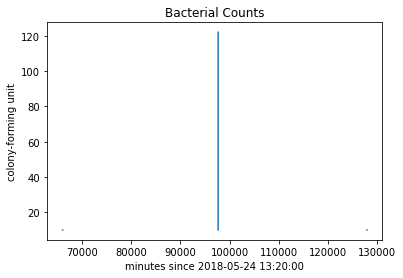

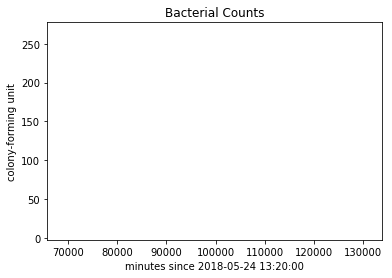

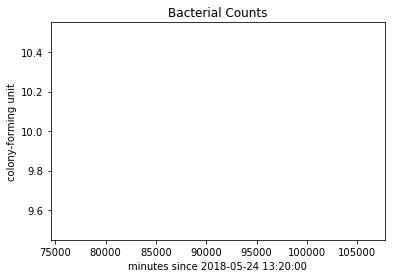

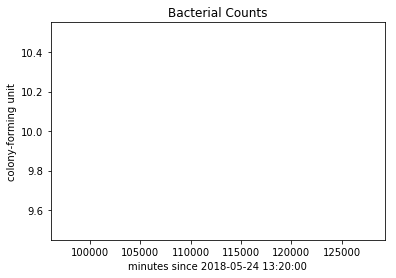

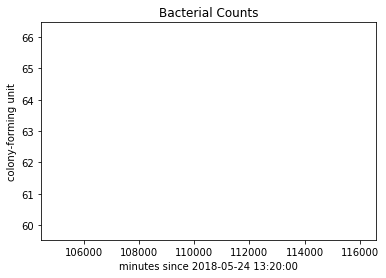

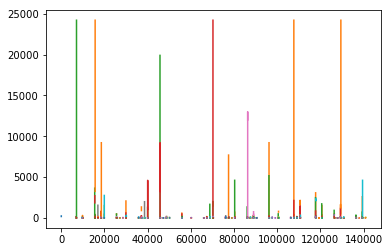

In [3]:
from netCDF4 import Dataset as NetCDFFile
import matplotlib.pyplot as plt
mydirectory = '/Users/bennysmith/Documents/Climate_Science/Research_with_Baylor'
ncstart = NetCDFFile(mydirectory+'/DOH_2018_FINAL.nc')
print(ncstart.variables.keys())
time = ncstart.variables['time']
SWresults = ncstart.variables['SWresults']
BeachID = ncstart.variables['BeachID']
Beach_Name = ncstart.variables['Beach Name']
print(SWresults)
for i in range(69):
    plt.plot(time, SWresults[:, i])
    plt.xlabel(time.units)
    plt.ylabel(SWresults.units)
    plt.title('Bacterial Counts')
    plt.show()
for i in range(69):
    plt.plot(time, SWresults[:, i])
plt.show()